In [ ]:
%pip install -r requirements.txt

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression





In [15]:
cr = pd.read_excel("data/customer_rating.xlsx")
print(cr.head())
cr['REGION'] = cr['REGION'].str.title()

# clean code and prepare 
# convert to date time format
cr["TIMESTAMP"] = pd.to_datetime(cr["TIMESTAMP"], unit="s")
print(cr[["TIMESTAMP"]].head()) #check
print(cr.isnull().sum())

cr = cr.dropna() #to double check
print(cr.isnull().sum())

    TIMESTAMP ISSUE_RESOLVED_ENUM SURVEY_TYPE FIXED_YN INTERNET_YN MOBILE_YN  \
0  1674691200        Not resolved       EMAIL       No          No       Yes   
1  1674777600        Not resolved       EMAIL      Yes         Yes        No   
2  1674777600        Not resolved       EMAIL       No         Yes       Yes   
3  1674518400        Not resolved       EMAIL      Yes         Yes        No   
4  1674604800        Not resolved  SMS-TO-SMS       No          No       Yes   

  TV_YN           REGION  CUSTOMER_SCORE  
0    No   Klein-Pöchlarn               0  
1   Yes  WIENER NEUSTADT               0  
2    No     Lichtenwörth               1  
3   Yes             Wien               1  
4    No             Wien               3  
   TIMESTAMP
0 2023-01-26
1 2023-01-27
2 2023-01-27
3 2023-01-24
4 2023-01-25
TIMESTAMP                 0
ISSUE_RESOLVED_ENUM    4668
SURVEY_TYPE               0
FIXED_YN                  0
INTERNET_YN               0
MOBILE_YN                 0
TV_YN          

# Taking some key info

In [21]:

cr['ISSUE_RESOLVED_ENUM'] = cr['ISSUE_RESOLVED_ENUM'].replace({ 'Yes - after single contact': 1,
    'Yes - after multiple contacts': 1,
    'Not resolved': 0})

reg_res_rate = cr.groupby('REGION')['ISSUE_RESOLVED_ENUM'].mean().reset_index()
top_regions = reg_res_rate.sort_values(by='ISSUE_RESOLVED_ENUM', ascending=False).head(10)
regions_sc1 = reg_res_rate[reg_res_rate['ISSUE_RESOLVED_ENUM'] == 1]
count_regions_sc1 = len(regions_sc1)
print(f"# of regions with a resolution success rate of 100%: {count_regions_sc1}")

top_regions = reg_res_rate.sort_values(by='ISSUE_RESOLVED_ENUM', ascending=False).head(10)
cases_regions_sc1 = cr[cr['REGION'].isin(regions_sc1['REGION'])]
n_cases_1 = len(cases_regions_sc1)
print(f"# cases in regions with a 100% resolution success rate: {n_cases_1}")

frac_tot_1 = n_cases_1 / len(cr)
print(f"% of cases from regions with a 100% resolution success rate: {frac_tot_1:.2%}")

regions_sc0 = reg_res_rate[reg_res_rate['ISSUE_RESOLVED_ENUM'] == 0]
casesregions_sc0 = cr[cr['REGION'].isin(regions_sc0['REGION'])]
n_cases_0 = len(casesregions_sc0)
print(f"# cases in regions with a 0% resolution success rate: {n_cases_0}")

frac_total_0 = n_cases_0 / len(cr)
print(f"% of cases from regions with a 0% resolution success rate: {frac_total_0:.2%}")

resolved_cases = cr[cr["ISSUE_RESOLVED_ENUM"] == 1].shape[0]
frac_resolved = resolved_cases / len(cr)
print(f"Total % of resolved cases: {frac_resolved:.2%}")

avg_res_rate = cr['ISSUE_RESOLVED_ENUM'].mean()
print(f"Avg resolution rate: {avg_res_rate:.2%}")

# of regions with a resolution success rate of 100%: 1199
# cases in regions with a 100% resolution success rate: 2082
% of cases from regions with a 100% resolution success rate: 19.39%
# cases in regions with a 0% resolution success rate: 187
% of cases from regions with a 0% resolution success rate: 1.74%
Total % of resolved cases: 83.15%
Avg resolution rate: 83.15%


In [20]:

anz_regions = cr['REGION'].value_counts()
u_regions = cr['REGION'].unique()
n_regions = len(u_regions)
print(f"Total unique regions: {n_regions}")
print(f"Top 10 by #:\n{anz_regions.head(10)}")


Total unique regions: 1766
Top 10 by #:
REGION
Wien               4450
Graz                516
Innsbruck           256
Klagenfurt          204
Linz                170
Salzburg            133
Wiener Neustadt     102
Dornbirn             71
Villach              66
Wels                 56
Name: count, dtype: int64


# Plot resolution rate in top 10 biggest (by # ofsurveys) regions

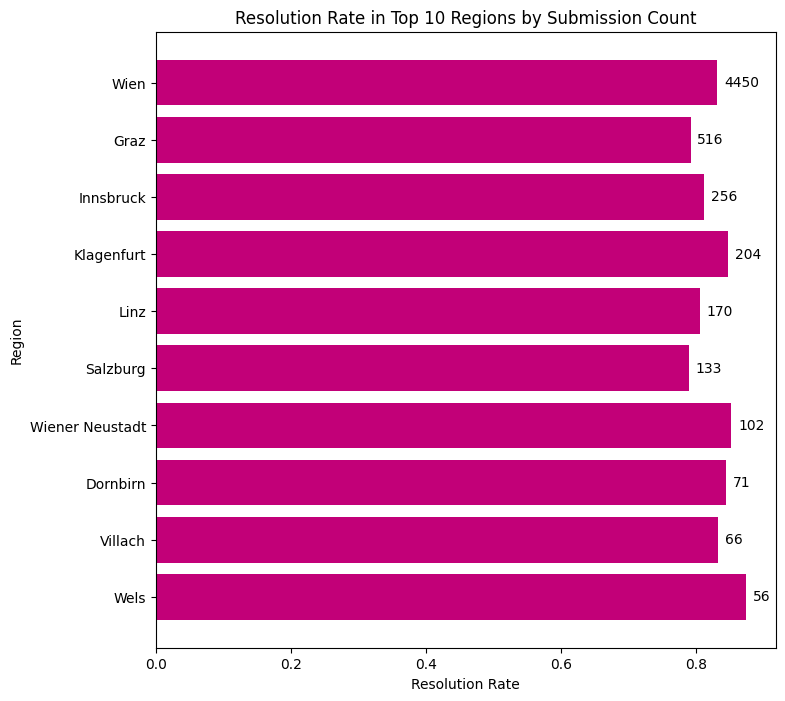

In [17]:

top_regions = anz_regions.head(10).index
cr_tregions = cr[cr['REGION'].isin(top_regions)]

cr_tregions.loc[:, 'ISSUE_RESOLVED_ENUM'] = cr_tregions['ISSUE_RESOLVED_ENUM'].replace({
    'Yes - after single contact': 1,
    'Yes - after multiple contacts': 1,
    'Not resolved': 0
})

submission_counts = cr_tregions['REGION'].value_counts().reset_index()
submission_counts.columns = ['REGION', 'Submission_Count']

region_resolution_rate = cr_tregions.groupby('REGION')['ISSUE_RESOLVED_ENUM'].mean().reset_index()

region_summary = pd.merge(region_resolution_rate, submission_counts, on='REGION')

region_summary_sorted = region_summary.sort_values(by=['Submission_Count', 'ISSUE_RESOLVED_ENUM'], ascending=[False, False])

region_summary_sorted['Resolution_Rate_%'] = (region_summary_sorted['ISSUE_RESOLVED_ENUM'] * 100).round(2)

plt.figure(figsize=(8, 8))
bars = plt.barh(
    region_summary_sorted['REGION'],
    region_summary_sorted['ISSUE_RESOLVED_ENUM'],
    color='xkcd:magenta'
)
plt.xlabel('Resolution Rate')
plt.ylabel('Region')
plt.title('Resolution Rate in Top 10 Regions by Submission Count')
plt.gca().invert_yaxis()  

for bar, count in zip( #KI assistance
        bars,
        region_summary_sorted['Submission_Count']):
    plt.text(
        bar.get_width() + 0.01, 
        bar.get_y() + bar.get_height() / 2,  
        f'{count}', 
        va='center',
        fontsize=10,
        color='black'
    )


plt.show()


# Summary with absolute and relative values

In [ ]:
print(region_summary_sorted)

            REGION  ISSUE_RESOLVED_ENUM  Submission_Count  Resolution_Rate_%
8             Wien             0.832135              4450              83.21
1             Graz             0.792636               516              79.26
2        Innsbruck             0.812500               256              81.25
3       Klagenfurt             0.848039               204              84.80
4             Linz             0.805882               170              80.59
5         Salzburg             0.789474               133              78.95
9  Wiener Neustadt             0.852941               102              85.29
0         Dornbirn             0.845070                71              84.51
6          Villach             0.833333                66              83.33
7             Wels             0.875000                56              87.50
